In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 4)

In [2]:
file_path = Path('..\\data\\csv\\FY_2022-2025.csv')
df = pd.read_csv(file_path)

numeric_cols = [
    c for c in df.columns
    if c not in {
        "Hospital CCN",
        "Penalty indicator for AMI",
        "Penalty indicator for COPD",
        "Penalty indicator for HF",
        "Penalty indicator for pneumonia",
        "Penalty indicator for CABG",
        "Penalty indicator for THA/TKA",
        "Year",
    }
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

print("Shape after load:", df.shape)
df.head()

Shape after load: (9063, 37)


,Hospital CCN,Payment adjustment factor,Payment reduction percentage,Dual proportion,Peer group assignment,Neutrality modifier,Number of eligible discharges for AMI,ERR for AMI,Peer group median ERR for AMI,Penalty indicator for AMI,...,ERR for CABG,Peer group median ERR for CABG,Penalty indicator for CABG,DRG payment ratio for CABG,Number of eligible discharges for THA/TKA,ERR for THA/TKA,Peer group median ERR for THA/TKA,Penalty indicator for THA/TKA,DRG payment ratio for THA/TKA,Year
0,10001,0.9975,0.25,0.173117,2.0,0.96524,296.0,0.948341,0.995616,N,...,0.950942,0.996568,N,0.030183,34.0,0.965370,0.988756,N,0.002398,2025
1,10005,1.0000,0.00,0.144119,1.0,0.96524,22.0,0.997197,0.995675,N,...,NaN,0.998203,N,NaN,144.0,0.849717,0.991263,N,0.031160,2025
2,10006,0.9967,0.33,0.121918,1.0,0.96524,315.0,0.970391,0.995675,N,...,1.084641,0.998203,Y,0.028868,90.0,0.976203,0.991263,N,0.008750,2025
3,10007,0.9947,0.53,0.213840,3.0,0.96524,9.0,1.013923,0.995781,N,...,NaN,0.994297,N,NaN,33.0,0.969486,0.996292,N,0.030986,2025
4,10008,1.0000,0.00,0.312693,4.0,0.96524,6.0,1.022645,0.997245,N,...,NaN,1.006131,N,NaN,NaN,NaN,0.990094,N,NaN,2025


In [3]:
# %% 2. Helper: RaR for one condition
def revenue_at_risk(row, condition):
    """Compute RaR ($) if ERR moved to peer median."""
    err_key = f"ERR for {condition}"
    median_key = f"Peer group median ERR for {condition}"
    drg_key = f"DRG payment ratio for {condition}"
    n_key = f"Number of eligible discharges for {condition}"

    # Missing any piece → NaN
    if pd.isna(row[err_key]) or pd.isna(row[median_key]) or pd.isna(row[drg_key]) or pd.isna(row[n_key]):
        return np.nan

    baseline = row[drg_key] * row[n_key]
    rel_change = (row[median_key] - row[err_key]) / row[err_key]
    new_revenue = baseline * (1 + rel_change)
    return new_revenue - baseline


In [4]:
conditions = ["AMI", "COPD", "HF", "pneumonia", "CABG", "THA/TKA"]
for cond in conditions:
    df[f"RaR_{cond}"] = df.apply(lambda r: revenue_at_risk(r, cond), axis=1)

# Total RaR across conditions
rar_cols = [f"RaR_{c}" for c in conditions]
df["Total_RaR"] = df[rar_cols].sum(axis=1, skipna=True)

df[["Hospital CCN"] + rar_cols + ["Total_RaR"]].head()

,Hospital CCN,RaR_AMI,RaR_COPD,RaR_HF,RaR_pneumonia,RaR_CABG,RaR_THA/TKA,Total_RaR
0,10001,0.393398,0.053403,-1.685250,0.277999,0.218676,0.001975,-0.739800
1,10005,-0.000156,0.425014,0.005679,2.490834,NaN,0.747447,3.668819
2,10006,0.359226,0.080807,0.535408,-0.551460,-0.209349,0.012149,0.226781
3,10007,-0.000745,-0.032144,-0.048774,-0.259777,NaN,0.028273,-0.313166
4,10008,-0.002177,0.007189,-0.002201,0.000211,NaN,NaN,0.003023


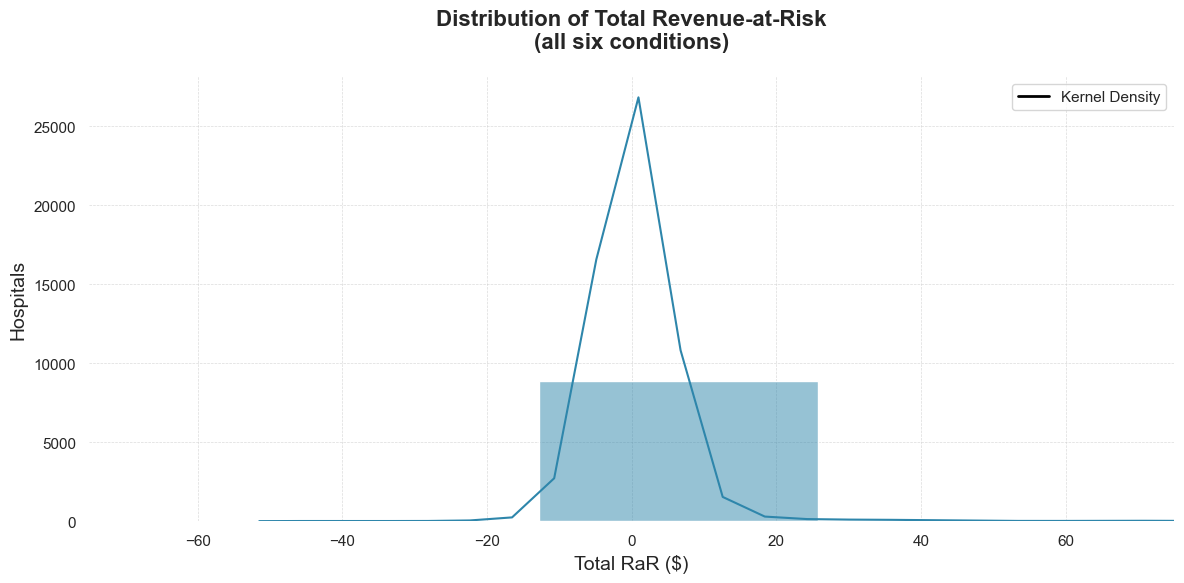

In [5]:
top_upside = (
    df[["Hospital CCN", "Total_RaR"]]
    .sort_values("Total_RaR", ascending=False)
    .head(10)
)
top_upside

plt.figure(figsize=(12, 6))  # Increased figure size
sns.set_theme(style="whitegrid", palette="mako")

ax = sns.histplot(
    data=df,
    x="Total_RaR",
    bins=30,  # Adjusted bin width for better resolution
    kde=True,
    color="#2E86AB",
    edgecolor="white",
    linewidth=1.0  # Thinner lines for better visibility
)

# Labels & formatting
ax.set_title("Distribution of Total Revenue-at-Risk\n(all six conditions)", pad=20, fontsize=16, weight="bold")
ax.set_xlabel("Total RaR ($)", fontsize=14)
ax.set_ylabel("Hospitals", fontsize=14)

# Limit x-axis to -75 to 75 dollars
plt.xlim(-75, 75)

# Legend for KDE line
from matplotlib.lines import Line2D
kde_line = Line2D([0], [0], color="black", lw=2, linestyle="-")
ax.legend([kde_line], ["Kernel Density"], loc="upper right")

# Gridlines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
N_SIM = 1000
sim_results = []

for _, row in df.iterrows():
    samples = []
    for cond in conditions:
        err_key = f"ERR for {cond}"
        median_key = f"Peer group median ERR for {cond}"
        drg_key = f"DRG payment ratio for {cond}"
        n_key = f"Number of eligible discharges for {cond}"

        if pd.isna(row[err_key]) or pd.isna(row[median_key]) or pd.isna(row[drg_key]) or pd.isna(row[n_key]):
            continue

        # Draw peer median with ±5 % normal noise
        median_sim = np.random.normal(loc=row[median_key], scale=0.05 * row[median_key], size=N_SIM)
        baseline = row[drg_key] * row[n_key]
        rel_change = (median_sim - row[err_key]) / row[err_key]
        new_rev = baseline * (1 + rel_change)
        samples.extend(new_rev - baseline)

    if samples:
        samples = np.array(samples)
        sim_results.append(
            {
                "Hospital CCN": row["Hospital CCN"],
                "mean_RaR": samples.mean(),
                "ci_lower": np.percentile(samples, 2.5),
                "ci_upper": np.percentile(samples, 97.5),
            }
        )

sim_df = pd.DataFrame(sim_results).sort_values("mean_RaR", ascending=False)


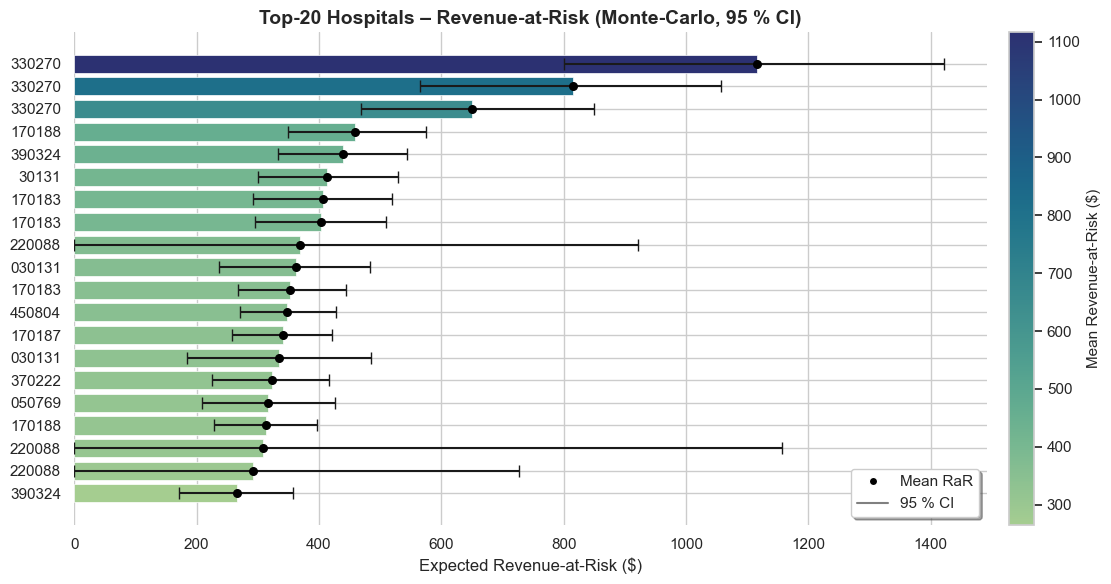

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

subset = sim_df.head(20).copy().sort_values("mean_RaR")
y_pos = np.arange(len(subset))

# colour map
cmap = sns.color_palette("crest", as_cmap=True)
norm = plt.Normalize(vmin=subset["mean_RaR"].min(), vmax=subset["mean_RaR"].max())

# bars
bars = plt.barh(
    y_pos,
    subset["mean_RaR"],
    xerr=[subset["mean_RaR"] - subset["ci_lower"],
          subset["ci_upper"] - subset["mean_RaR"]],
    capsize=4,
    color=cmap(norm(subset["mean_RaR"])),
    edgecolor="white",
    linewidth=.5,
)

# dot on the bar
plt.scatter(subset["mean_RaR"], y_pos, color="black", s=30, zorder=3)

# color-bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label("Mean Revenue-at-Risk ($)", fontsize=11)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markersize=6, label='Mean RaR'),
    Line2D([0], [0], color='gray', lw=1.5, label='95 % CI')
]
plt.legend(handles=legend_elements, loc="lower right", frameon=True, shadow=True)

# labels
plt.yticks(y_pos, subset["Hospital CCN"], fontsize=11)
plt.xlabel("Expected Revenue-at-Risk ($)", fontsize=12)
plt.title("Top-20 Hospitals – Revenue-at-Risk (Monte-Carlo, 95 % CI)", fontsize=14, weight="bold")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()